In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.4. Outcome Prediction/Output')
cur_date = "111325"

library(readxl)
library(tidyverse)
library(factoextra)
library(Hmisc)
library(ggsci)
library(ggrepel)

# reading in files
saliva_df = data.frame(read_excel("Input/Processed_Saliva_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE))
stool_df = data.frame(read_excel("Input/Processed_Stool_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE)) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [9]:
combined_saliva_df = saliva_df %>%
    # normalizing
    mutate(across(c(10:ncol(saliva_df)), ~ log(.x + 2))) %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))
combined_stool_df = stool_df %>%
    mutate(across(c(11:ncol(stool_df)), ~ log(.x + 2))) %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

# Comparing Baseline Bacteria Abundances

In [3]:
v1_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples and those given active treatment
    filter(Time_Point == 'Pre' & Treatment == 'A') %>%
    # making the row names the sample ids
    column_to_rownames(var = 'Sample_ID') 

v1_stool_df = combined_stool_df %>%
    filter(Time_Point == 'Pre' & Treatment == 'A') %>%
    column_to_rownames(var = 'Sample_ID') 

head(v1_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pre_2,FS02baseline,2,Pre,A,Failure,1.354280,2.7850112,Low,0.6931472,2.8903718,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
Pre_4,FS05baseline,4,Pre,A,Failure,1.790389,2.4501427,Low,3.2580965,0.6931472,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
Pre_6,FS07baseline,6,Pre,A,Sustained Unresponsiveness,1.229400,1.1999648,Low,2.1972246,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197
Pre_9,FS10baseline,9,Pre,A,Sustained Unresponsiveness,1.220547,0.8837675,Low,2.3978953,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.280697,8.360773,0.6931472,0.6931472,0.6931472,0.6931472,2.197225
Pre_11,FS12baseline,11,Pre,A,Failure,1.271759,1.8468788,Low,2.3025851,0.6931472,⋯,0.6931472,0.6931472,0.6931472,2.890372,8.445482,0.6931472,0.6931472,3.6635616,2.1972246,3.496508
Pre_14,FS15baseline,14,Pre,A,Failure,1.777040,4.6728288,High,1.3862944,0.6931472,⋯,2.3025851,0.6931472,0.6931472,3.555348,5.575949,0.6931472,0.6931472,7.2909748,4.0943446,4.060443


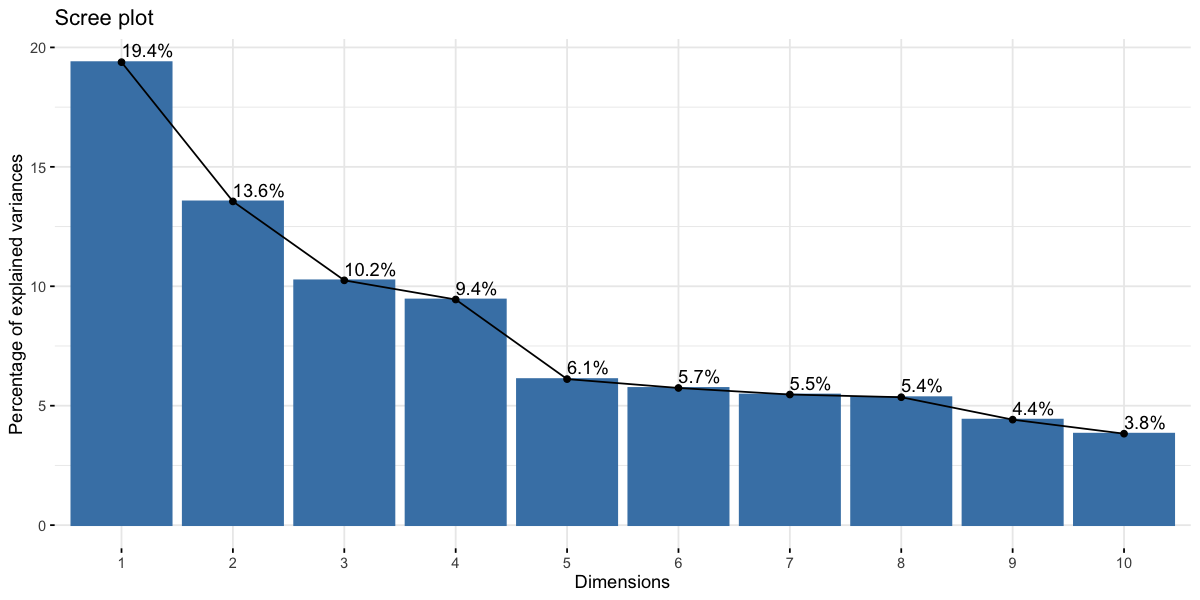

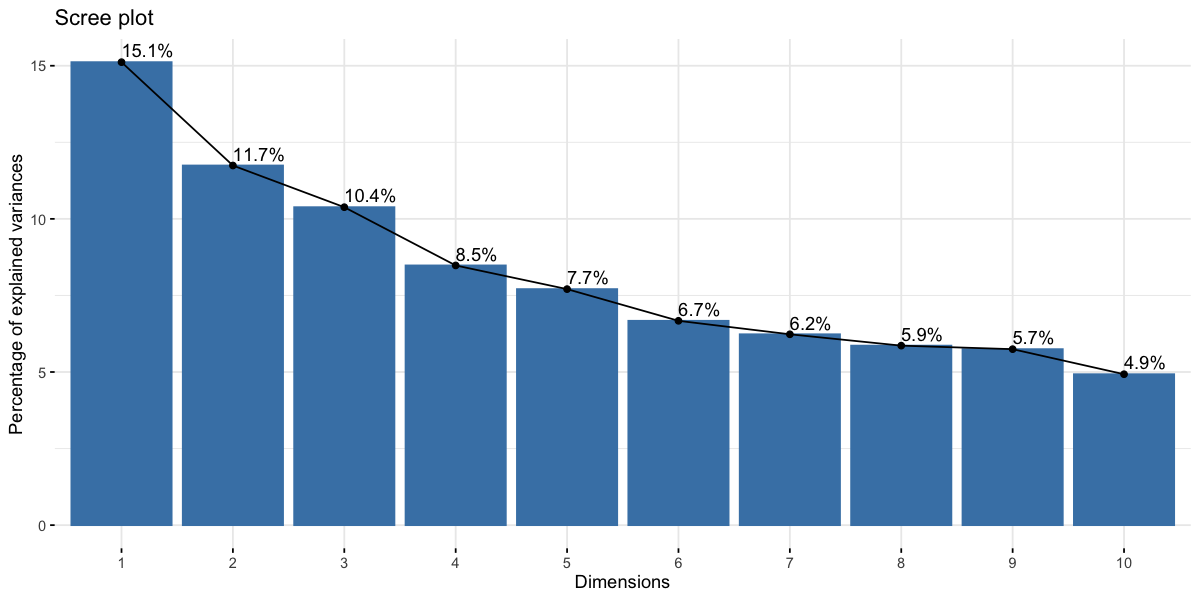

In [11]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = v1_saliva_df[,c(6,7,9:ncol(v1_saliva_df))]
pca_stool_df = v1_stool_df[,c(7,8,10:ncol(v1_stool_df))]

# running pca 
saliva_pca = prcomp(pca_saliva_df, center = TRUE, scale = TRUE)
stool_pca = prcomp(pca_stool_df, center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

In [12]:
# saliva_baseline_pca_df = data.frame(saliva_pca$x[,1:2]) %>%
#                rownames_to_column(var = "SampleID")
# stool_baseline_pca_df = data.frame(stool_pca$x[,1:2]) %>%
#                rownames_to_column(var = "SampleID")

# saliva_bl_pca_df = inner_join(saliva_baseline_pca_df,v1_saliva_df[,1:8] %>% 
#                                      rownames_to_column(var = "SampleID")) %>%
#     # cleaning variable names here
#     mutate(Outcome = ifelse(Outcome == "F", "Failure",
#                                   ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))
# stool_bl_pca_df = inner_join(stool_baseline_pca_df,v1_stool_df[,1:8] %>% 
#                                      rownames_to_column(var = "SampleID")) %>%
#     # cleaning variable names here
#     mutate(Outcome = ifelse(Outcome == "F", "Failure",
#                                   ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

# head(saliva_bl_pca_df)

In [13]:
# options(repr.plot.width=12, repr.plot.height=7) #changing size
# ggplot() + 
#   geom_point(data = saliva_bl_pca_df, aes(x = PC1, y = PC2, color = Outcome, shape = Outcome),
#              size = 3.5) + 
#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
#   geom_text_repel(data = saliva_bl_pca_df, 
#                   aes(x = PC1, y = PC2, color = Outcome, label = SampleID), 
#                   segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

#   theme_light() + 
#   theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
#         axis.line = element_line(colour="black"), #making x and y axes black
#         axis.text = element_text(size = 13), #changing size of x axis labels
#         legend.title = element_text(face = 'bold', size = 15), #changes legend title
#         legend.text = element_text(size = 12), #changes legend text
#         legend.position = "bottom", 
#         legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
#         axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
#         strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
#         strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

#   labs(x = 'Dimension 1 (30%)', y = 'Dimension 2 (24.9%)', #changing axis labels 
#        color = "Outcome", shape = "Outcome") + #changing legend title

#   scale_color_lancet() 

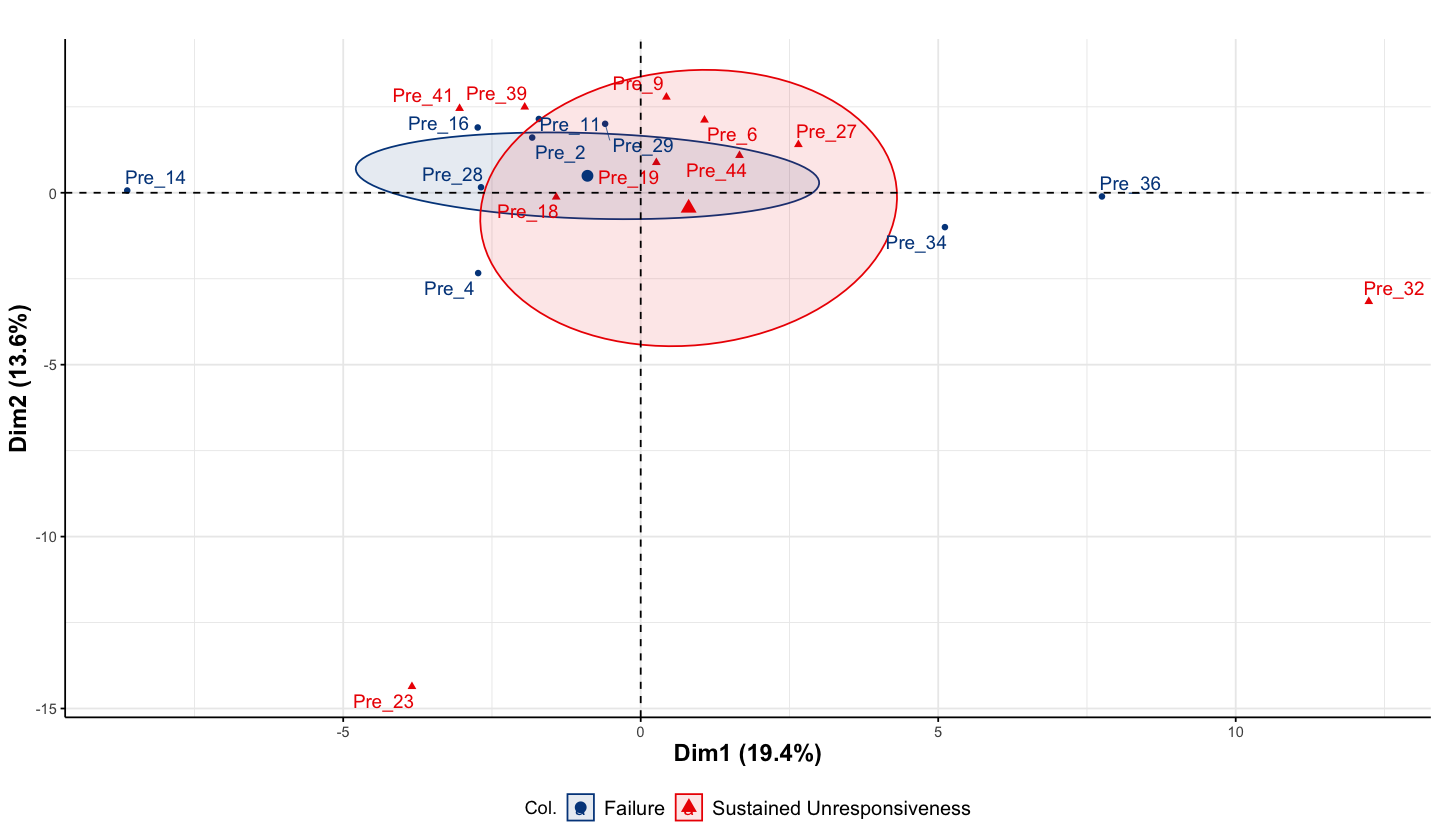

In [12]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = v1_saliva_df$Outcome, # color by Group
             palette = 'lancet',
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

In [15]:
# ggplot() + 
#   geom_point(data = stool_bl_pca_df, aes(x = PC1, y = PC2, color = Outcome, shape = Outcome),
#              size = 3.5) + 
#   stat_ellipse(data = stool_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
#   geom_text_repel(data = stool_bl_pca_df, 
#                   aes(x = PC1, y = PC2, color = Outcome, label = SampleID), 
#                   segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

#   theme_light() + 
#   theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
#         axis.line = element_line(colour="black"), #making x and y axes black
#         axis.text = element_text(size = 13), #changing size of x axis labels
#         legend.title = element_text(face = 'bold', size = 15), #changes legend title
#         legend.text = element_text(size = 12), #changes legend text
#         legend.position = "bottom", 
#         legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
#         axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
#         strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
#         strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

#   labs(x = 'Dimension 1 (28%)', y = 'Dimension 2 (20%)', #changing axis labels 
#        color = "Outcome", shape = "Outcome") + #changing legend title

#   scale_color_lancet() 

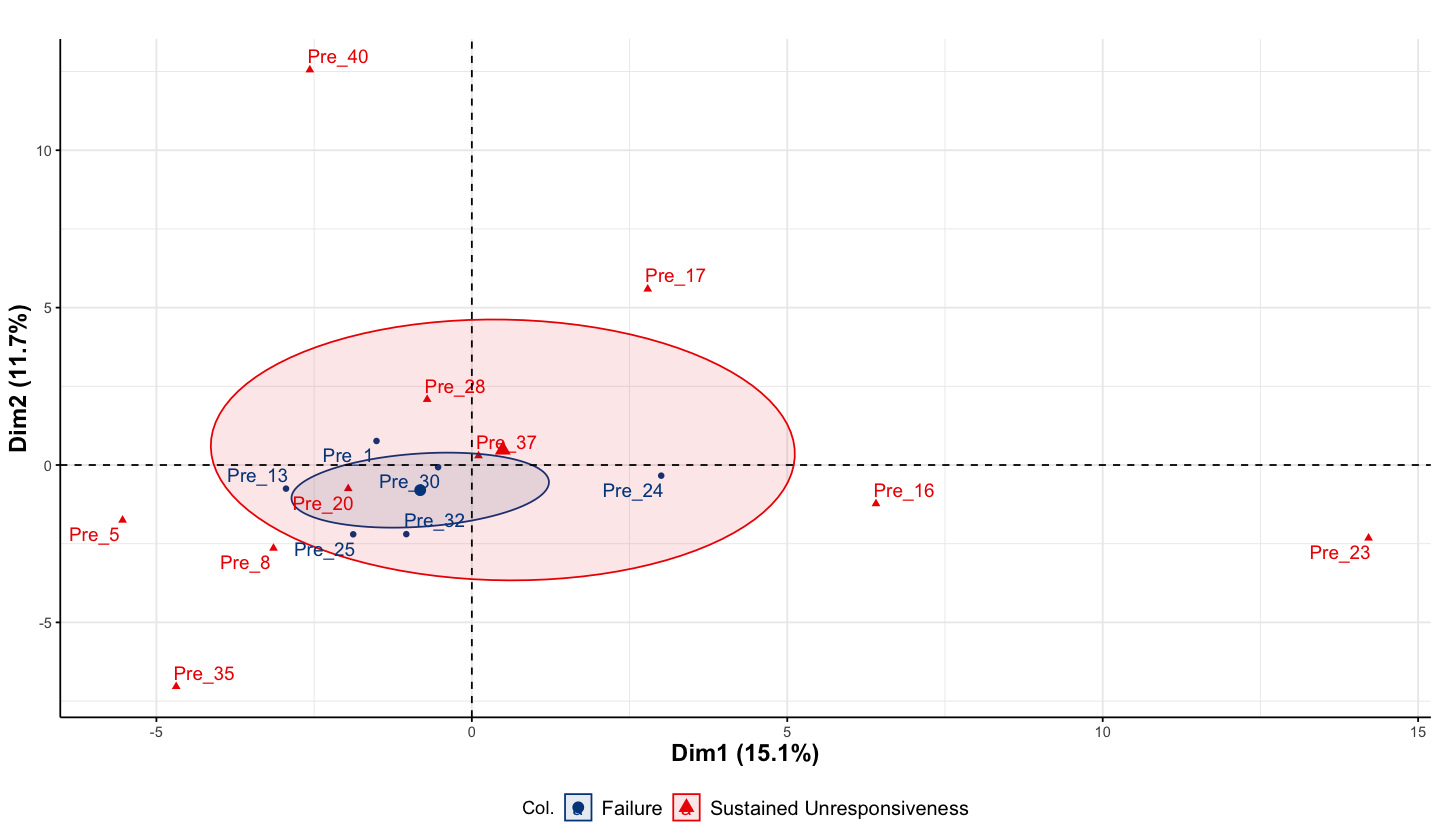

In [13]:
fviz_pca_ind(stool_pca, 
             col.ind = v1_stool_df$Outcome, # color by Group
             palette = 'lancet',
             # #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
 theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

In [14]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA subject outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x[,1:2]
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)            
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)

## Comparing IgE levels before treatment

In [36]:
v2_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples 
    filter(Time_Point == 'Pre') %>%#, Sample_ID != 'Pre_1') %>%
    # # removing 12 highly correlated bacteria 
    # select(!occurences_saliva_df$Var1) %>%
    # making the row names the sample ids
    column_to_rownames(var = 'Sample_ID')

v2_stool_df = combined_stool_df %>%
     filter(Time_Point == 'Pre') %>%#, Sample_ID != 'Pre_14') %>%
    column_to_rownames(var = 'Sample_ID')

head(v2_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pre_1,FS01baseline,1,Pre,P,Failure,3.838356,41.00,High,2.1972246,3.4657359,⋯,4.0775374,2.7080502,0.6931472,5.3706380,6.655440,0.6931472,2.7725887,5.5134287,3.8286414,4.1896547
Pre_2,FS02baseline,2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,2.8903718,⋯,0.6931472,0.6931472,3.8712010,5.9215784,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.7361984
Pre_3,FS04baseline,3,Pre,P,Failure,3.715068,67.40,High,1.7917595,0.6931472,⋯,0.6931472,0.6931472,0.6931472,0.6931472,3.806662,6.0306853,3.8918203,0.6931472,1.3862944,6.9584484
Pre_4,FS05baseline,4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,0.6931472,⋯,0.6931472,0.6931472,0.6931472,4.7184989,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.1298987
Pre_5,FS06baseline,5,Pre,P,Failure,2.356164,106.00,High,4.4308168,2.5649494,⋯,0.6931472,0.6931472,3.9512437,6.2441669,7.980708,0.6931472,0.6931472,0.6931472,0.6931472,0.6931472
Pre_6,FS07baseline,6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.7480285,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.4011974


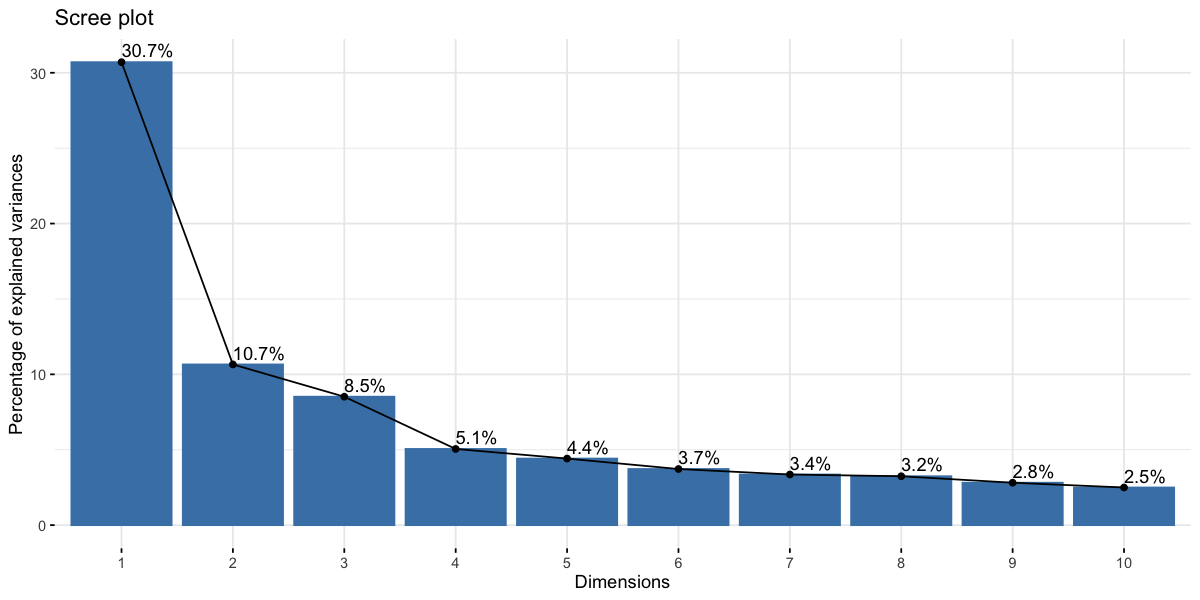

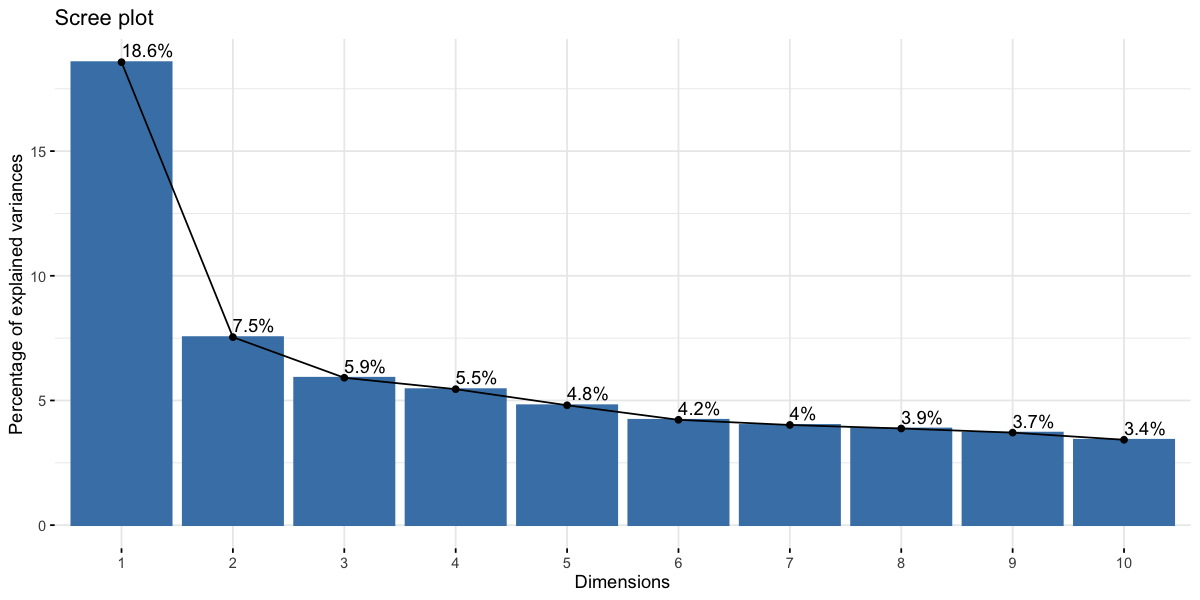

In [39]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = v2_saliva_df[,c(6,9:ncol(v2_saliva_df))]
pca_stool_df = v2_stool_df[,c(7,10:ncol(v2_stool_df))]

# running pca 
saliva_pca = prcomp(pca_saliva_df, center = FALSE, scale = TRUE)
stool_pca = prcomp(pca_stool_df, center = FALSE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

In [17]:
# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)  
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)

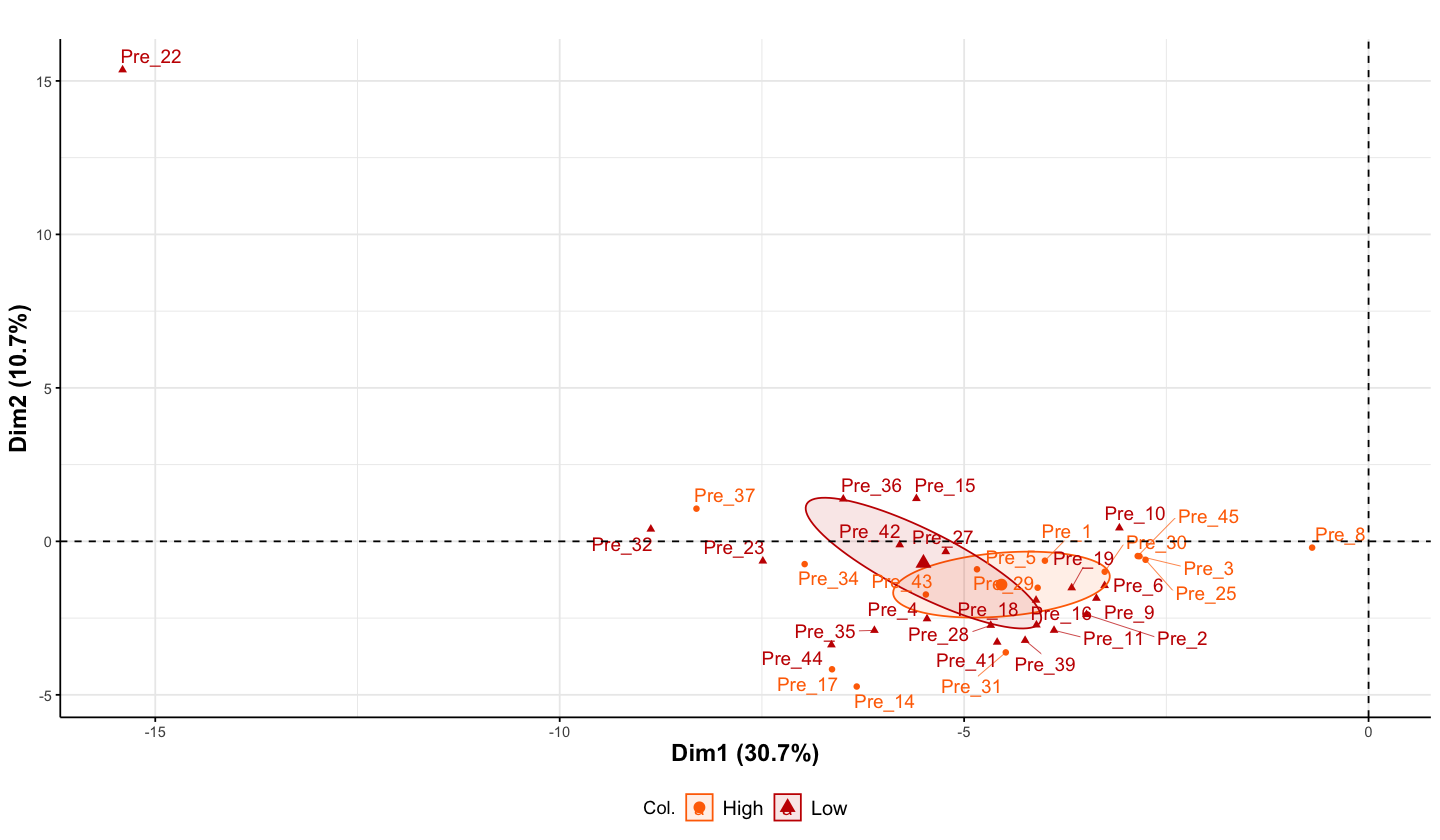

In [40]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = v2_saliva_df$IgE_Binarized, # color by Group
             palette = 'futurama',
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

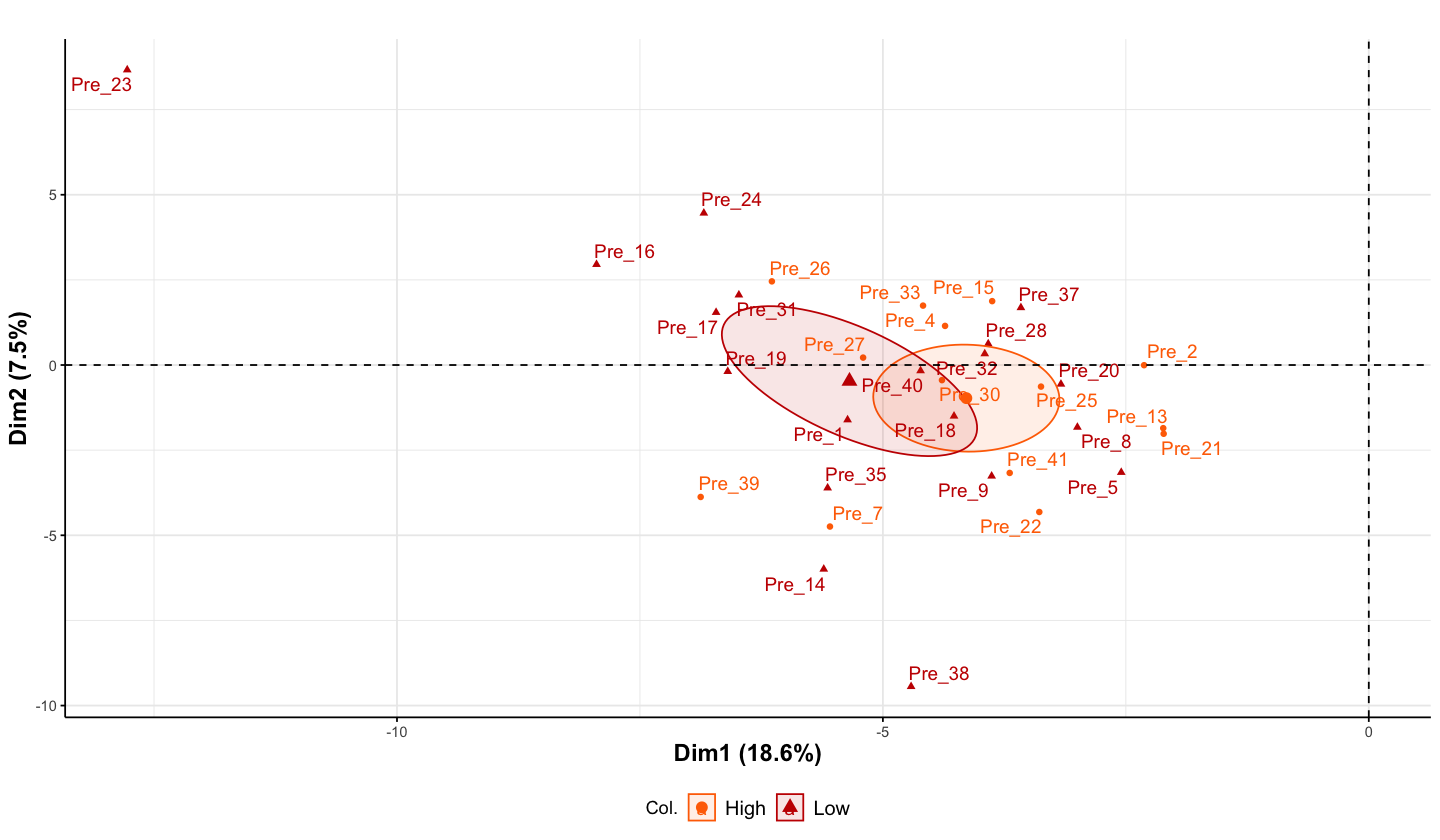

In [19]:
fviz_pca_ind(stool_pca, 
             col.ind = v2_stool_df$IgE_Binarized, # color by Group
             palette = 'futurama',
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

# PCA based on Time Point recieving Active Treatment

Note: For this analysis, I included participants that only pre or post data to maximize the sample size.

In [55]:
`%notin%` <- Negate(`%in%`)

paired_saliva_df = saliva_df  %>%
    # removing those failed the IgE protein
    filter(IgE_Binarized != 'Fail')  %>%
    # ended up reassinging 'DS' to 'F' due to small sample size
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    # # removing 12 highly correlated bacteria 
    # select(!occurences_saliva_df$Var1) %>%
    # removing 13 participants that don't have pre and post samples
    # keeping subject 20, 24, 26 that have post but not pre data
    filter(#Subject_No %notin% c(1,12,13,16,17,31,32,36,37,43),
    # retaining those given treatment
          Treatment == 'A') %>%
    column_to_rownames('Sample_ID') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

paired_stool_df = stool_df  %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
     # removing 10 participants that don't have pre and post samples
    # keeping subject 3, 10 that have post but not pre data
    filter(#Subject_No %notin% c(14,15,23,25,27,32,35,39),
          Treatment == 'A') %>%
    column_to_rownames('Sample_ID') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

head(paired_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Post_2,FS0236mo,2,Post,A,Failure,1.873973,14.20,Low,63,25,⋯,698,0,43,98,1657,0,0,423,146,123
Pre_2,FS02baseline,2,Pre,A,Failure,1.873973,14.20,Low,0,16,⋯,0,0,46,371,3359,0,0,0,0,112
Post_4,FS0536mo,4,Post,A,Failure,3.991781,9.59,Low,6,0,⋯,0,17,0,139,2521,0,0,502,39,101
Pre_4,FS05baseline,4,Pre,A,Failure,3.991781,9.59,Low,24,0,⋯,0,0,0,110,1225,40,4,403,35,167
Post_6,FS0736mo,6,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,2,24,⋯,0,0,0,463,1646,7,0,167,61,437
Pre_6,FS07baseline,6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,7,0,⋯,0,0,0,2315,1978,0,16,0,5,28


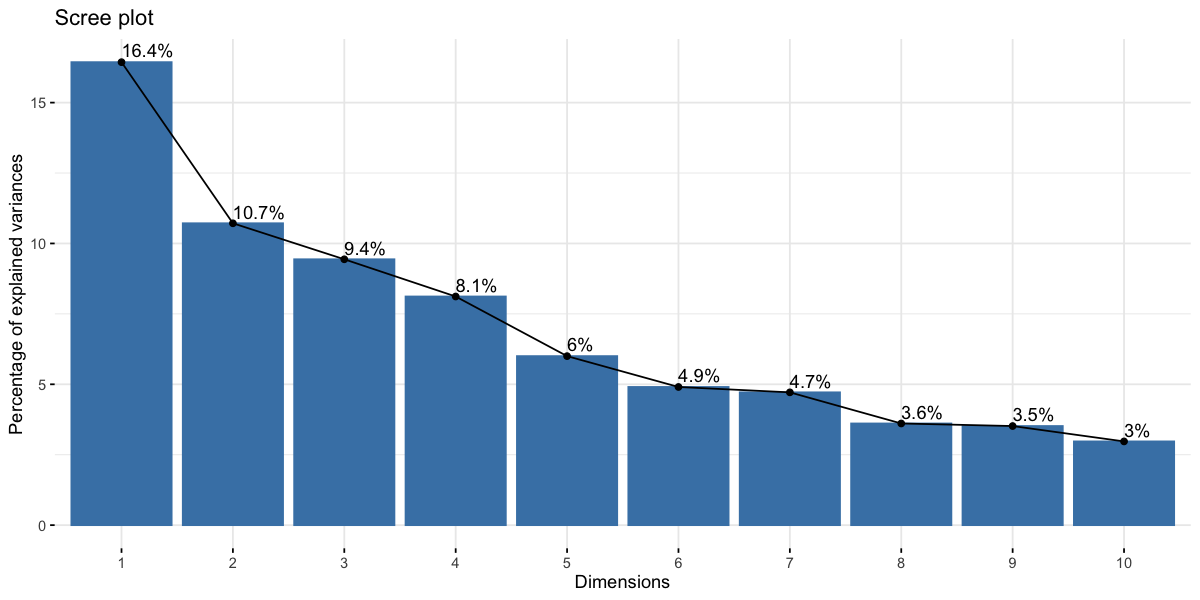

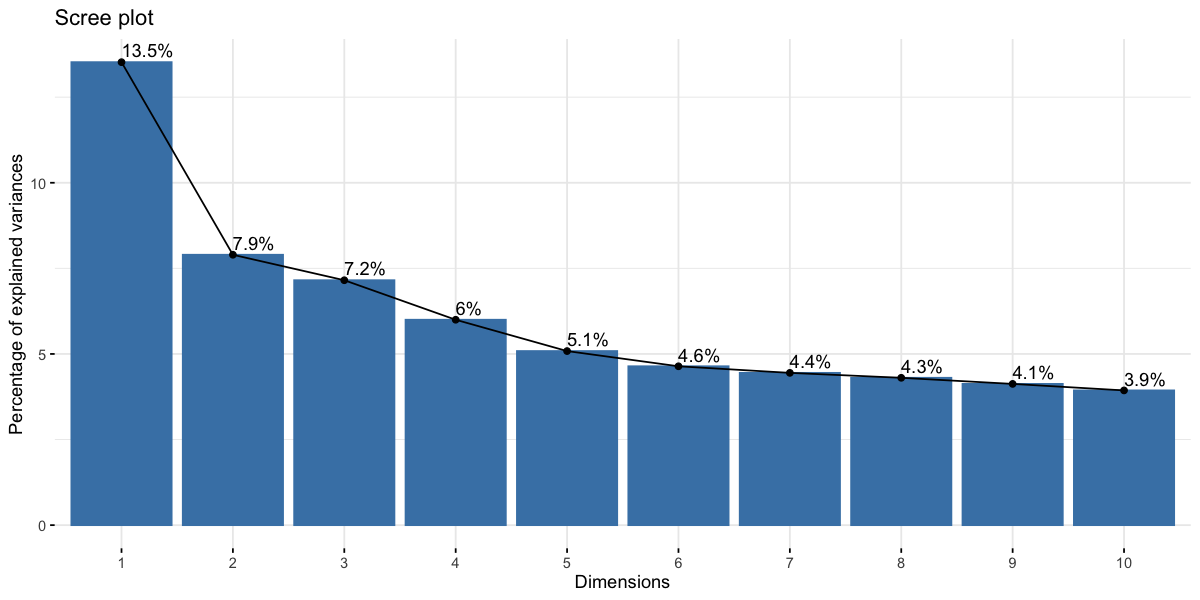

In [42]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = paired_saliva_df[,c(6,9:ncol(paired_saliva_df))]
pca_stool_df = paired_stool_df[,c(7,10:ncol(paired_stool_df))]

# running pca 
saliva_pca = prcomp(pca_saliva_df, center = TRUE, scale = TRUE)
stool_pca = prcomp(pca_stool_df, center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

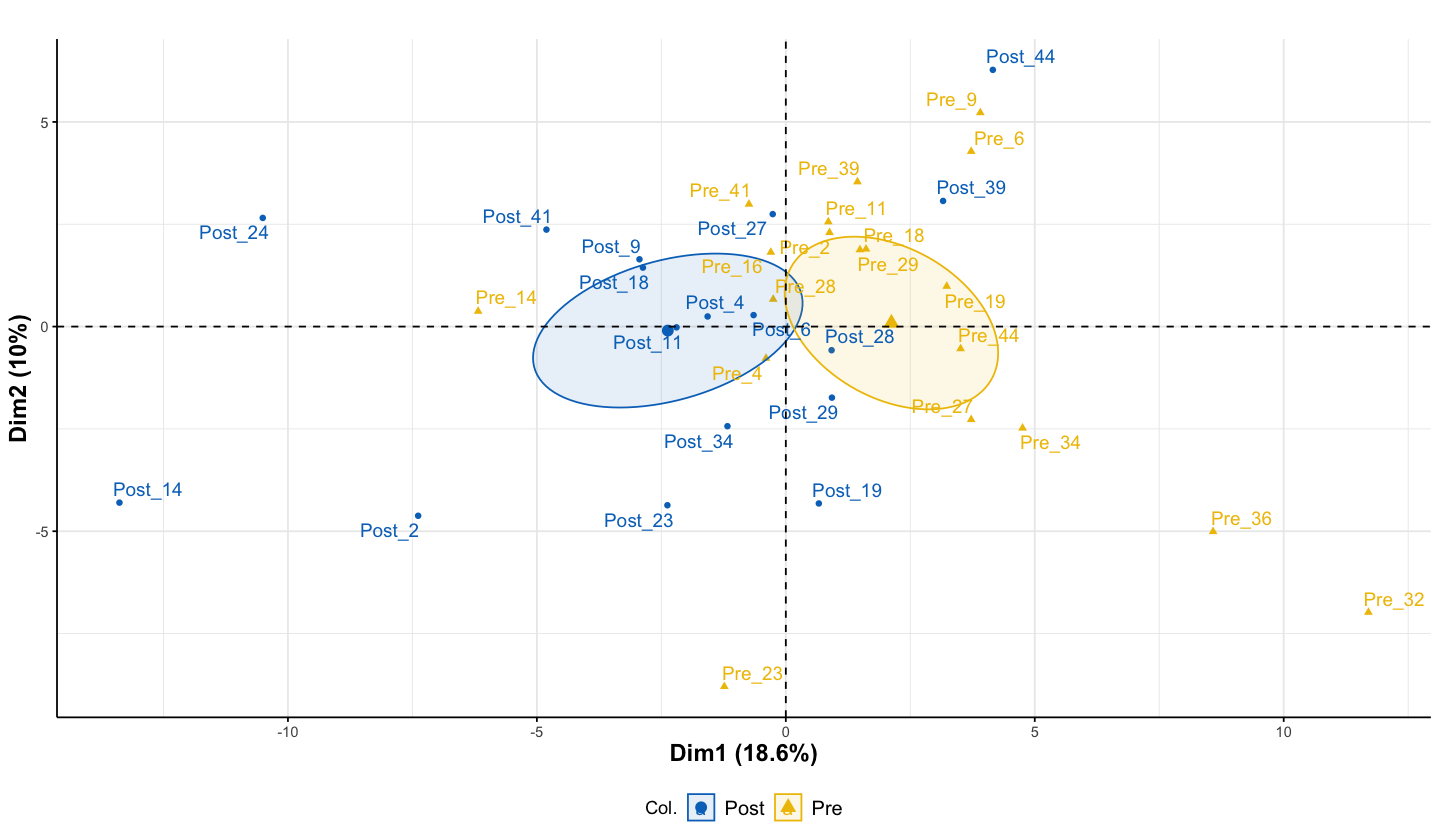

In [36]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = paired_saliva_df$Time_Point, # color by Group
             palette = 'jco',
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

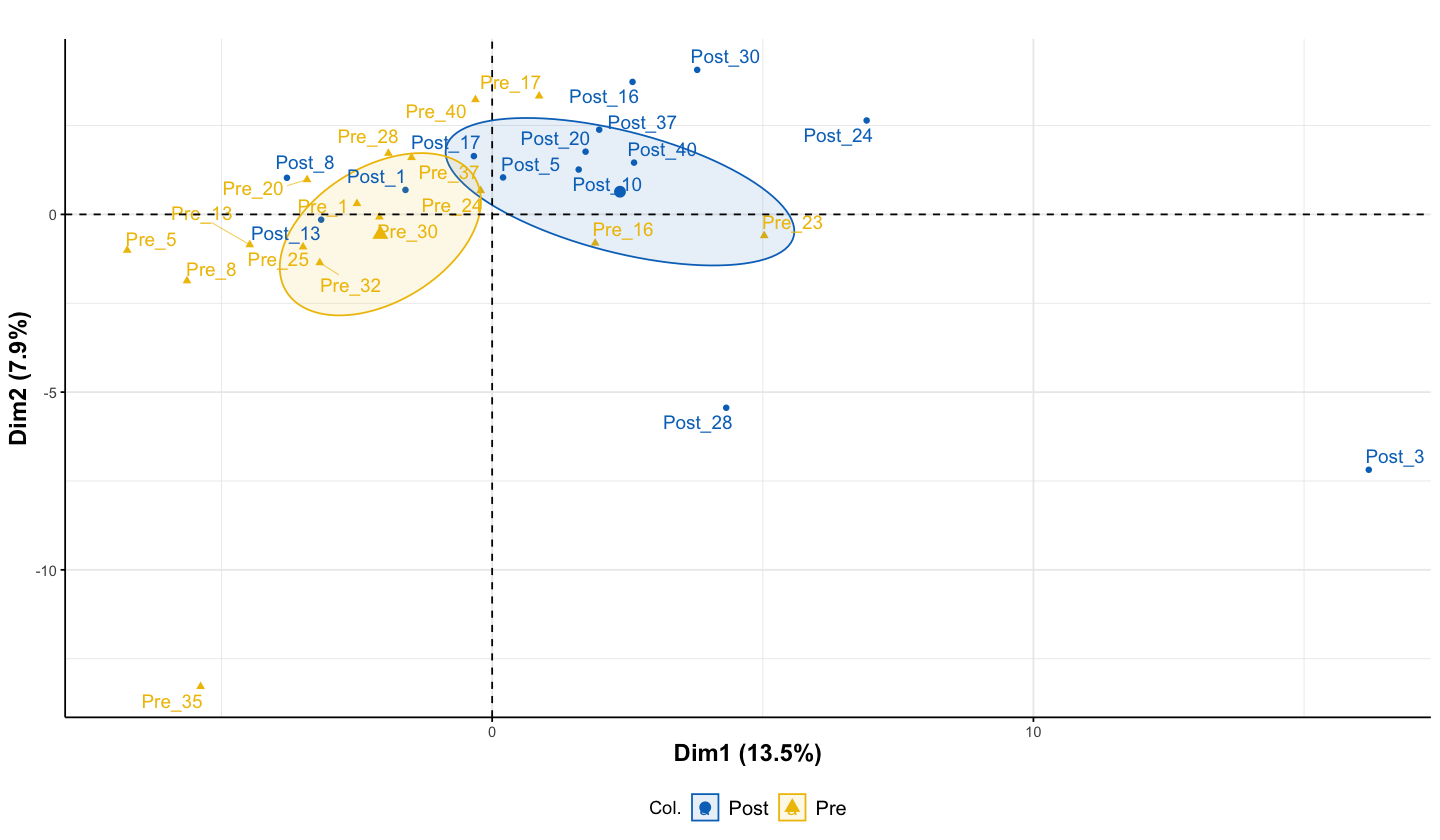

In [37]:
fviz_pca_ind(stool_pca, 
             col.ind = paired_stool_df$Time_Point, # color by Group
             palette = 'jco',
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

In [23]:
# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)  
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)

In [25]:
library(umap)
# setting seed for reproducibility
set.seed(12)

saliva_umap_outcome = umap(v1_saliva_df[,c(10:ncol(v1_saliva_df))])
stool_umap_outcome = umap(v1_stool_df[,c(11:ncol(v1_stool_df))])

saliva_umap_outcome_df = data.frame(X = saliva_umap_outcome$layout[,1],
                     Y = saliva_umap_outcome$layout[,2],
                     Outcome = v1_saliva_df$Outcome,
                     Age = v1_saliva_df$Age) %>%
    rownames_to_column('Sample_ID')

stool_umap_outcome_df = data.frame(X = stool_umap_outcome$layout[,1],
                     Y = stool_umap_outcome$layout[,2],
                     Outcome = v1_stool_df$Outcome,
                     Age = v1_stool_df$Age) %>%
    rownames_to_column('Sample_ID')

head(saliva_umap_outcome_df)

,Sample_ID,X,Y,Outcome,Age
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,Pre_2,-0.1454943,-0.3435196,Failure,1.354280
2,Pre_4,-0.4851280,1.5567184,Failure,1.790389
3,Pre_6,-0.9459406,-1.2102404,Sustained Unresponsiveness,1.229400
4,Pre_9,-1.0052694,-0.8737762,Sustained Unresponsiveness,1.220547
5,Pre_11,-0.7200397,-0.3953887,Failure,1.271759
6,Pre_14,-0.9770446,1.1342831,Failure,1.777040


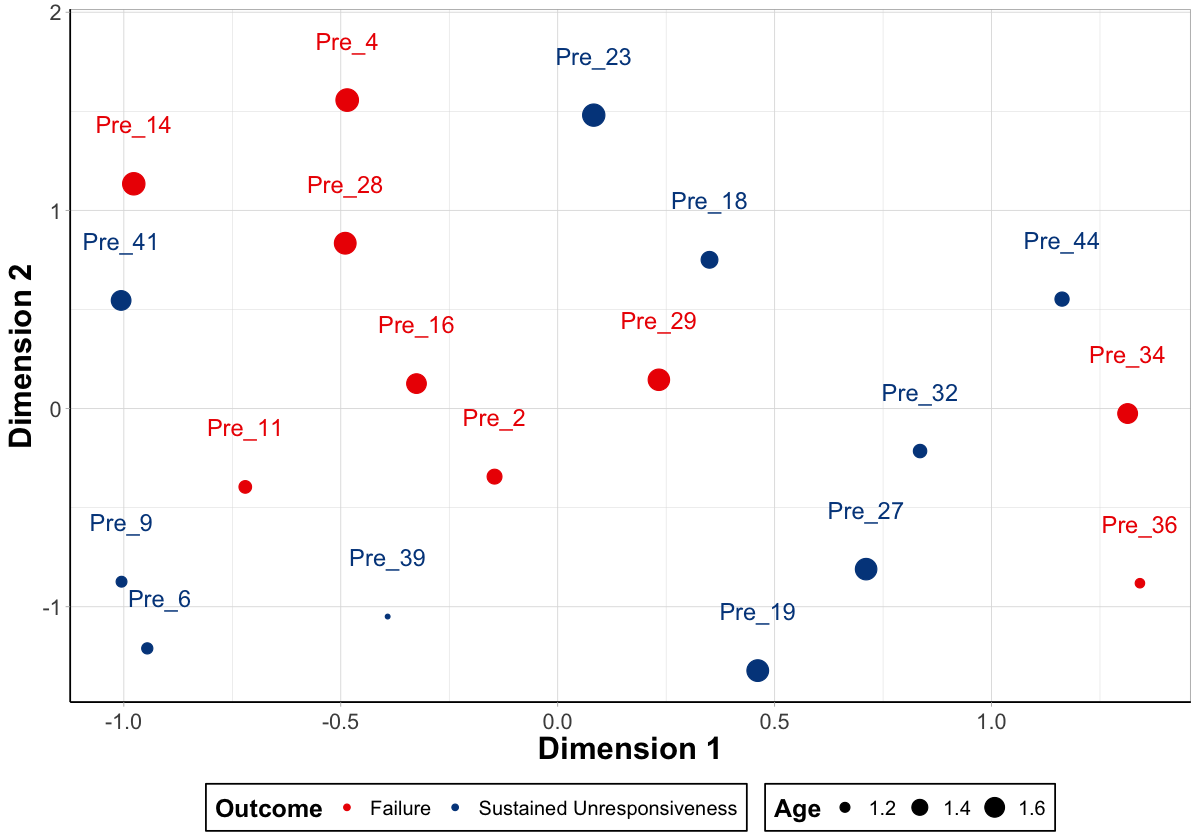

In [34]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
lancet_palette = pal_lancet()(2)

ggplot(saliva_umap_outcome_df, aes(x = X, y = Y, color = Outcome, size = Age)) + 
  geom_point() + 

#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
  geom_text_repel(data = saliva_umap_outcome_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))
  #scale_color_gradient(low = "#5ab4ac", high = "#d8b365")

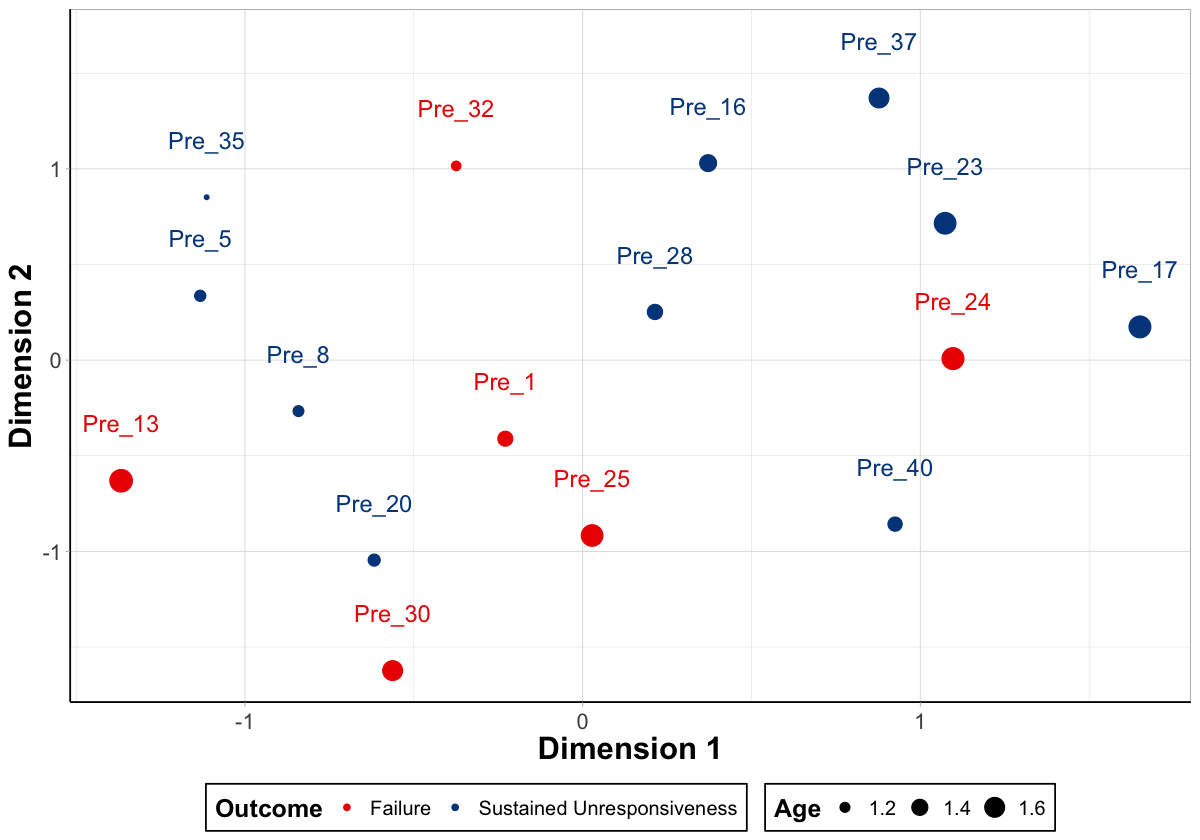

In [35]:
ggplot(stool_umap_outcome_df, aes(x = X, y = Y, color = Outcome, size = Age)) + 
 geom_point() + 

#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
  geom_text_repel(data = stool_umap_outcome_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

In [52]:
# setting seed for reproducibility
set.seed(12)

saliva_umap_ige = umap(v2_saliva_df[,c(10:ncol(v2_saliva_df))])
stool_umap_ige = umap(v2_stool_df[,c(11:ncol(v2_stool_df))])

saliva_umap_ige_df = data.frame(X = saliva_umap_ige$layout[,1],
                     Y = saliva_umap_ige$layout[,2],
                     IgE = v2_saliva_df$IgE_Binarized,
                     Age = v2_saliva_df$Age) %>%
    rownames_to_column('Sample_ID')

stool_umap_ige_df = data.frame(X = stool_umap_ige$layout[,1],
                     Y = stool_umap_ige$layout[,2],
                     IgE = v2_stool_df$IgE_Binarized,
                     Age = v2_stool_df$Age) %>%
    rownames_to_column('Sample_ID')

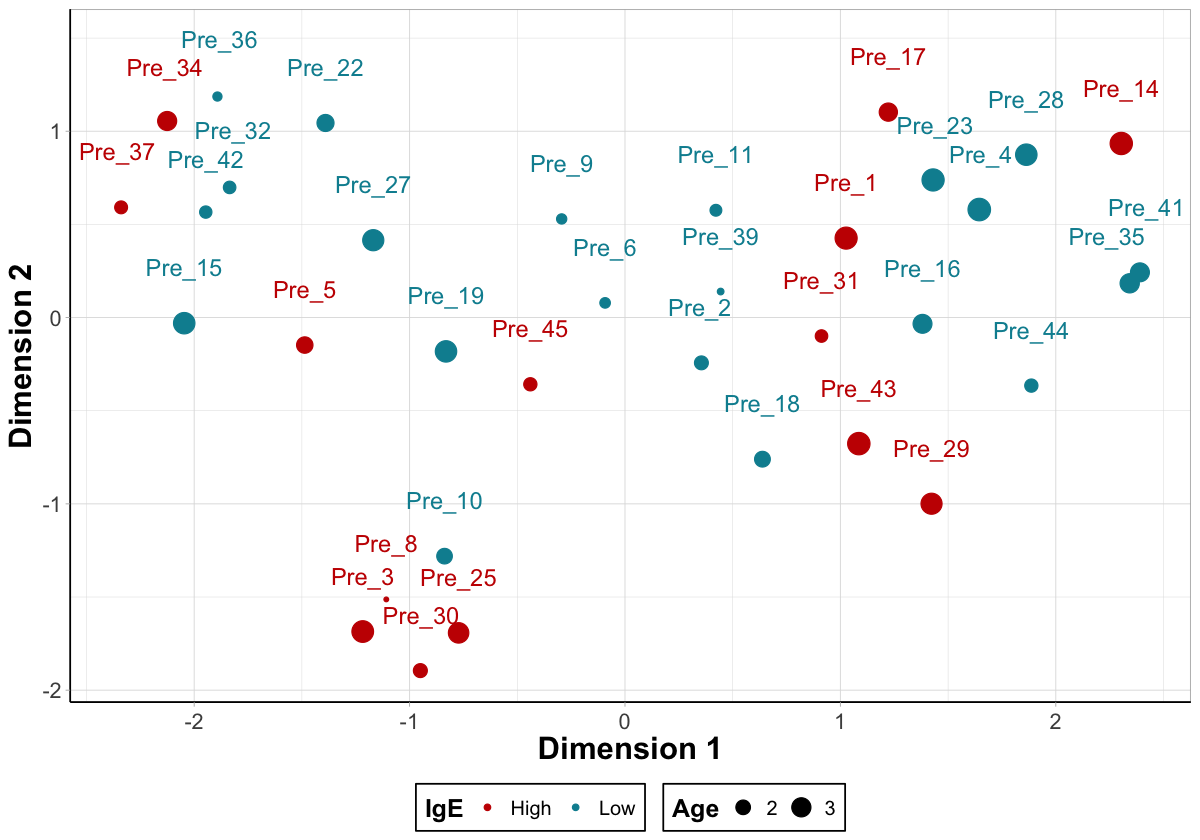

In [53]:
futurama_palette = pal_futurama()(3)

ggplot(saliva_umap_ige_df, aes(x = X, y = Y, color = IgE, size = Age)) + 
  geom_point() + 

#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
  geom_text_repel(data = saliva_umap_ige_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = futurama_palette[2:3])

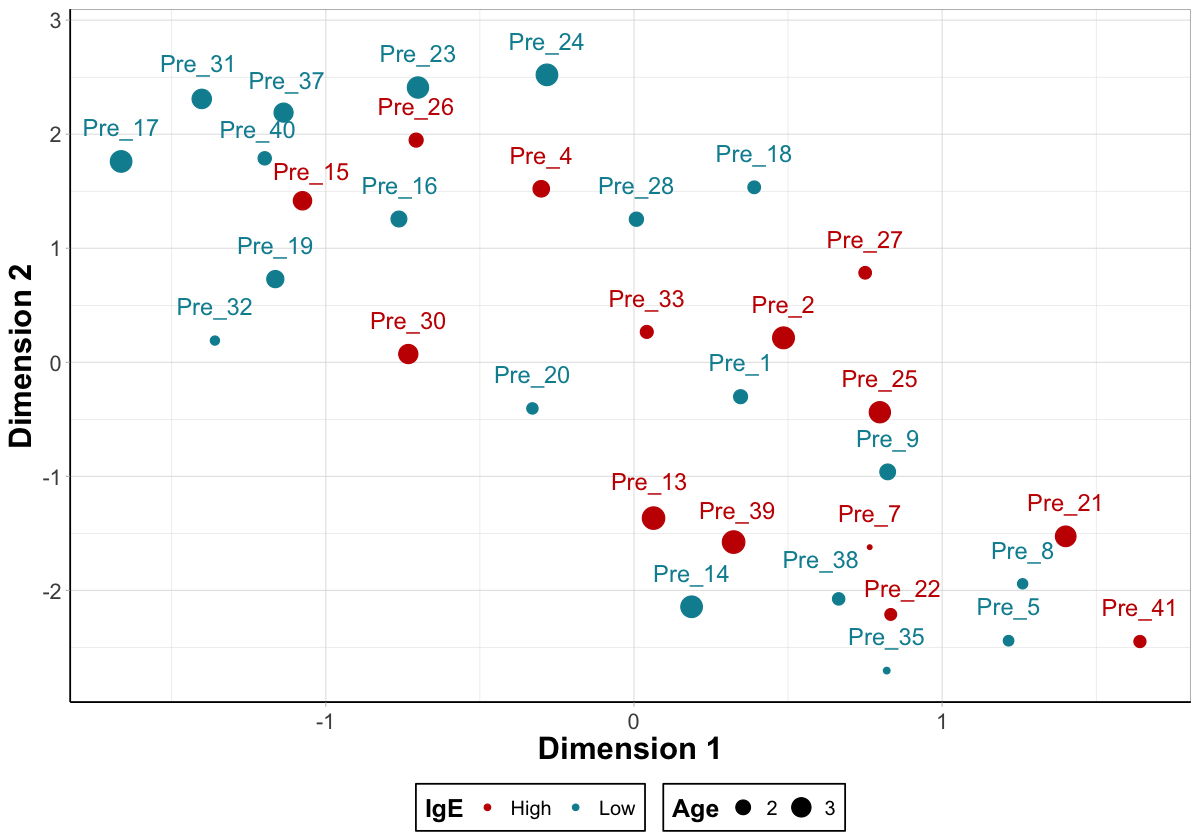

In [54]:
ggplot(stool_umap_ige_df, aes(x = X, y = Y, color = IgE, size = Age)) + 
  geom_point() + 

#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
  geom_text_repel(data = stool_umap_ige_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = futurama_palette[2:3])

In [59]:
set.seed(12)

saliva_umap_paired = umap(paired_saliva_df[,c(10:ncol(paired_saliva_df))])
stool_umap_paired = umap(paired_stool_df[,c(11:ncol(paired_stool_df))])

saliva_umap_paired_df = data.frame(X = saliva_umap_paired$layout[,1],
                     Y = saliva_umap_paired$layout[,2],
                     Outcome = paired_saliva_df$Outcome,
                     Age = paired_saliva_df$Age,
                     IgE = paired_saliva_df$IgE_Binarized) %>%
    rownames_to_column('Sample_ID')

stool_umap_paired_df = data.frame(X = stool_umap_paired$layout[,1],
                     Y = stool_umap_paired$layout[,2],
                     Outcome = paired_stool_df$Outcome,
                     Age = paired_stool_df$Age,
                     IgE = paired_stool_df$IgE_Binarized) %>%
    rownames_to_column('Sample_ID')

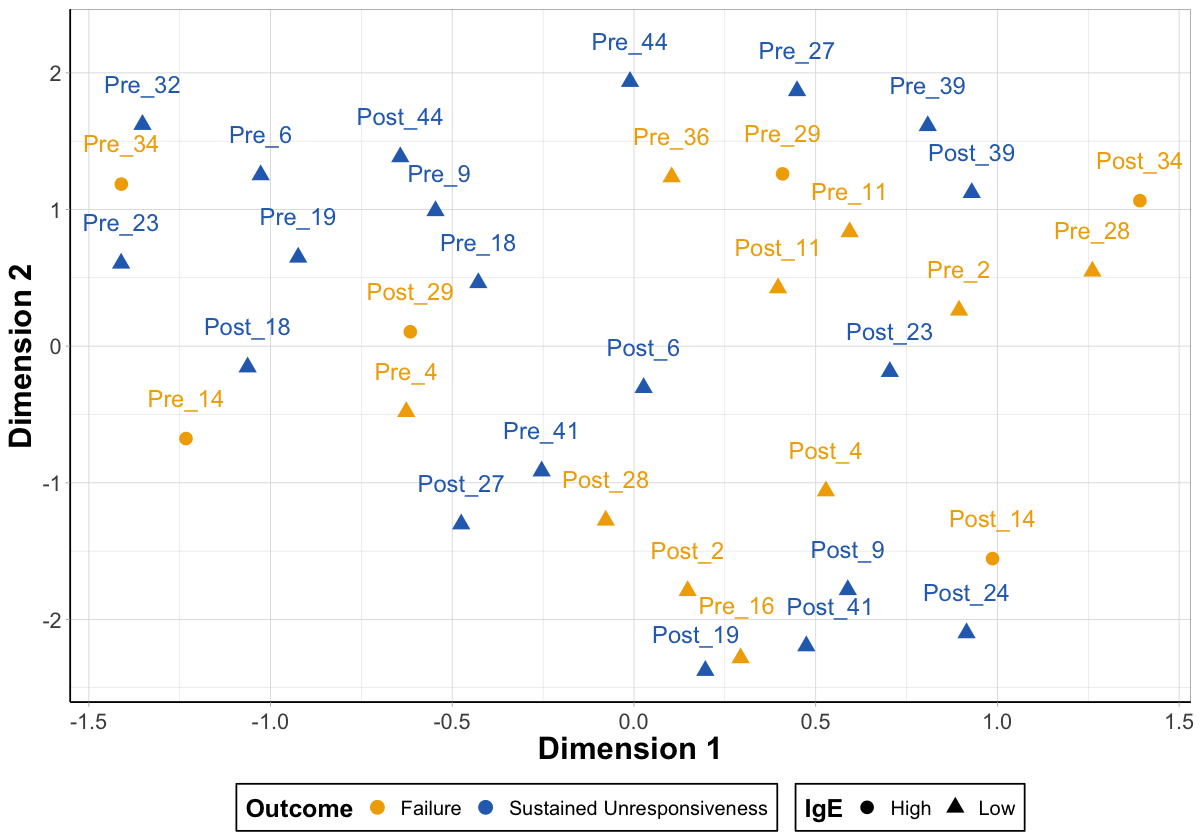

In [62]:
bmj_palette = pal_bmj()(2)

ggplot(saliva_umap_paired_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 

#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
  geom_text_repel(data = saliva_umap_paired_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(bmj_palette))

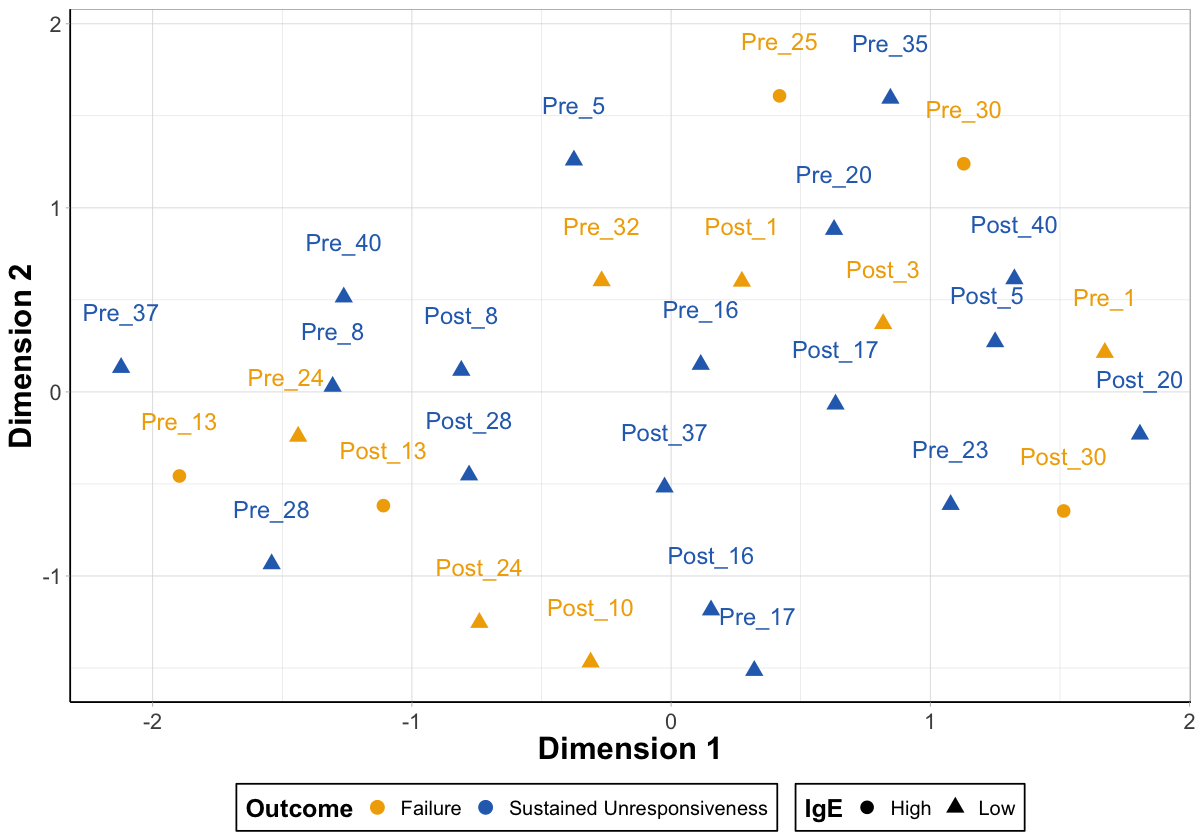

In [63]:
ggplot(stool_umap_paired_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 

#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
  geom_text_repel(data = stool_umap_paired_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(bmj_palette))